# DF_1

## Comprensión del Negocio y de los Datos:

### Definición del problema desde el negocio

* **Clasificar a los clientes como prospectos de compra de vehículo tomando en cuenta las variables dadas.**
* **Tipificar o asignar niveles de interés para compra de vehículo en su previa clasificación.**

### En que se va a usar la solución?

* **Enfocar los esfuerzos de venta en los prospectos dependiendo de su nivel dado anteriormente.**

### Como es el enfoque del problema (supervisado/no-supervisado/semi-supervisado)?

* **No supervisado, ya que no se tiene información de los niveles de interés de los prospectos.**

### Como podemos medir el problema?

* **Se puede medir el éxito de la solución mediante la siguiente métricas: Método de la Silueta**

## Identificación de objetivos de negocio y traducción en objetivos de análisis de datos

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

df_customer = pd.read_csv('DB_1.csv')

In [3]:
df_customer.isnull().sum()

Occupation              10
Monthly Income          13
Credit Score            40
Years of Employment     43
Finance Status          23
Finance History         28
Car                     20
Number of Children     125
dtype: int64

In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Occupation           490 non-null    object 
 1   Monthly Income       487 non-null    object 
 2   Credit Score         460 non-null    float64
 3   Years of Employment  457 non-null    object 
 4   Finance Status       477 non-null    object 
 5   Finance History      472 non-null    object 
 6   Car                  480 non-null    object 
 7   Number of Children   375 non-null    object 
dtypes: float64(1), object(7)
memory usage: 31.4+ KB


## Limpieza y Preprocesamiento de Datos:

/home/felipe/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


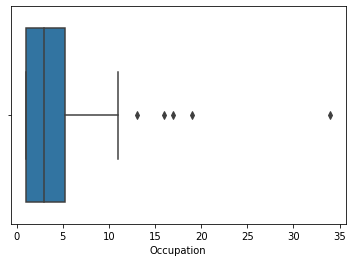

In [5]:
occupation_count = df_customer['Occupation'].value_counts()

sns.boxplot(occupation_count)

plt.show()

In [6]:
df_customer[df_customer['Occupation'].isna()]

Occupation Monthly Income  Credit Score Years of Employment  \
10         NaN            NaN           NaN                 NaN   
72         NaN            NaN           NaN                 NaN   
93         NaN            NaN           NaN                 NaN   
134        NaN            NaN           NaN                 NaN   
196        NaN            NaN           NaN                 NaN   
218        NaN            NaN           NaN                 NaN   
270        NaN            NaN           NaN                 NaN   
352        NaN            NaN           NaN                 NaN   
456        NaN            NaN           NaN                 NaN   
478        NaN            NaN           NaN                 NaN   

    Finance Status Finance History  Car Number of Children  
10             NaN             NaN  NaN                NaN  
72             NaN             NaN  NaN                NaN  
93             NaN             NaN  NaN                NaN  
134            NaN             NaN  NaN                NaN  
196            NaN             NaN  NaN                NaN  
218            NaN             NaN  NaN                NaN  
270            NaN             NaN  NaN                NaN  
352            NaN             NaN  NaN                NaN  
456            NaN             NaN  NaN                NaN  
478            NaN             NaN  NaN                NaN

Funcion de limpieza de los datos:

In [13]:
def limpieza_df_customer(df):
    """Limpia el DataFrame de clientes.

    Args:
        df (pandas.DataFrame): DataFrame de clientes.

    Returns:
        pandas.DataFrame: DataFrame de clientes limpio.
    """

    # Elimina las filas con valores faltantes en la ocupación.
    df.dropna(subset=["Occupation"], inplace=True)

    # Limpia los datos de los ingresos mensuales.
    df["Monthly Income"] = df["Monthly Income"].apply(
        lambda x: x.lower()
        .replace("$", "")
        .replace("usd", "")
        .replace("k", "00")
        .replace(",", ".")
        .strip() if isinstance(x, str) else x
    )

    # Elimina las filas con valores vacíos en los ingresos mensuales.
    df.dropna(subset=["Monthly Income"], inplace=True)

    # Elimina las filas con la ocupación "Bibliotecario".
    df.drop(df[df["Occupation"] == "Librarian"].index, inplace=True)

    # Imputa los valores faltantes de los ingresos mensuales para los diseñadores gráficos y asistentes médicos.
    df.loc[
        (df["Monthly Income"].isna()) & (df["Occupation"] == "Graphic Designer"),
        "Monthly Income",
    ] = df[(df["Occupation"] == "Graphic Designer")]["Monthly Income"].median()
    df.loc[
        (df["Monthly Income"].isna()) & (df["Occupation"] == "Medical Assistant"),
        "Monthly Income",
    ] = df[(df["Occupation"] == "Medical Assistant")]["Monthly Income"].median()

     # Elimina las filas con valores faltantes en la calificación crediticia.
    df.dropna(subset=["Credit Score"], inplace=True)

    # Imputa los valores faltantes de la calificación crediticia.
    df["Credit Score"] = df["Credit Score"].groupby(df["Occupation"]).apply(
        lambda x: x.fillna(x.median())
    )
    df["Monthly Income"] = df["Monthly Income"].apply(lambda x: float(x) if isinstance(x, str) else x)

    df["Monthly Income"] = df["Monthly Income"].apply(lambda x: int(round(x)))

   

    # Imputa los valores faltantes de los años de empleo.
    df["Years of Employment"] = df["Years of Employment"].apply(
        lambda x: x.lower()
        .replace("years", "")
        .replace("year", "")
        .replace("y", "")
        .strip() if isinstance(x, str) else x
    )
    df["Years of Employment"] = df["Years of Employment"].fillna(0)
    df["Years of Employment"] = df["Years of Employment"].astype(int)

    # Limpia los datos del estado financiero.
    df["Finance Status"] = df["Finance Status"].replace(
        {"Unknow": "Unknown", "Unkonw": "Unknown"}
    )
    df["Finance Status"] = df["Finance Status"].fillna("Unknown")

    # Limpia los datos del historial financiero.
    df["Finance History"] = df["Finance History"].replace(
        {
            "Late payment 2 months ago": "Late payment",
            "Late payment 6 months ago": "Late payment",
            "Late payment 3 months ago": "Late payment",
            "Late payment 1 month ago": "Late payment",
            "Late payments": "Late payment",
            "Late payments, collections": "Late payment",
            "No significant issues": "No significant issue",
            "Missed payments in the past": "Missed payment",
            "Missed payments, collections, charge-offs": "Missed payment",
        }
    )
    df["Finance History"] = df["Finance History"].fillna("Unknown")

    # Limpia los datos del número de hijos.
    df["Number of Children"] = df["Number of Children"].replace({"na": np.nan})
    df["Number of Children"] = df["Number of Children"].astype("float")
    df["Number of Children"] = df["Number of Children"].fillna(
        df["Number of Children"].median()
    )
    df["Number of Children"] = df["Number of Children"].astype(int)

    # Elimina las filas con valores faltantes en el auto.
    df.dropna(subset=["Car"], inplace=True)

    # Codifica la variable "Car" a valores numéricos.
    df["Car"] = df["Car"].replace({"Yes": 1, "No": 0})

    return df

In [14]:
df_1 = limpieza_df_customer(df_customer)

In [23]:
df_1.isnull().sum()

Occupation             0
Monthly Income         0
Credit Score           0
Years of Employment    0
Finance Status         0
Finance History        0
Car                    0
Number of Children     0
dtype: int64

In [15]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Occupation           478 non-null    object 
 1   Monthly Income       478 non-null    int64  
 2   Credit Score         478 non-null    float64
 3   Years of Employment  478 non-null    int64  
 4   Finance Status       478 non-null    object 
 5   Finance History      478 non-null    object 
 6   Car                  478 non-null    int64  
 7   Number of Children   478 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 33.6+ KB


## Análisis Exploratorio de Datos (EDA):

In [16]:
df_1_dum = pd.get_dummies(df_1, columns=['Occupation', 'Finance Status', 'Finance History'], drop_first=True)

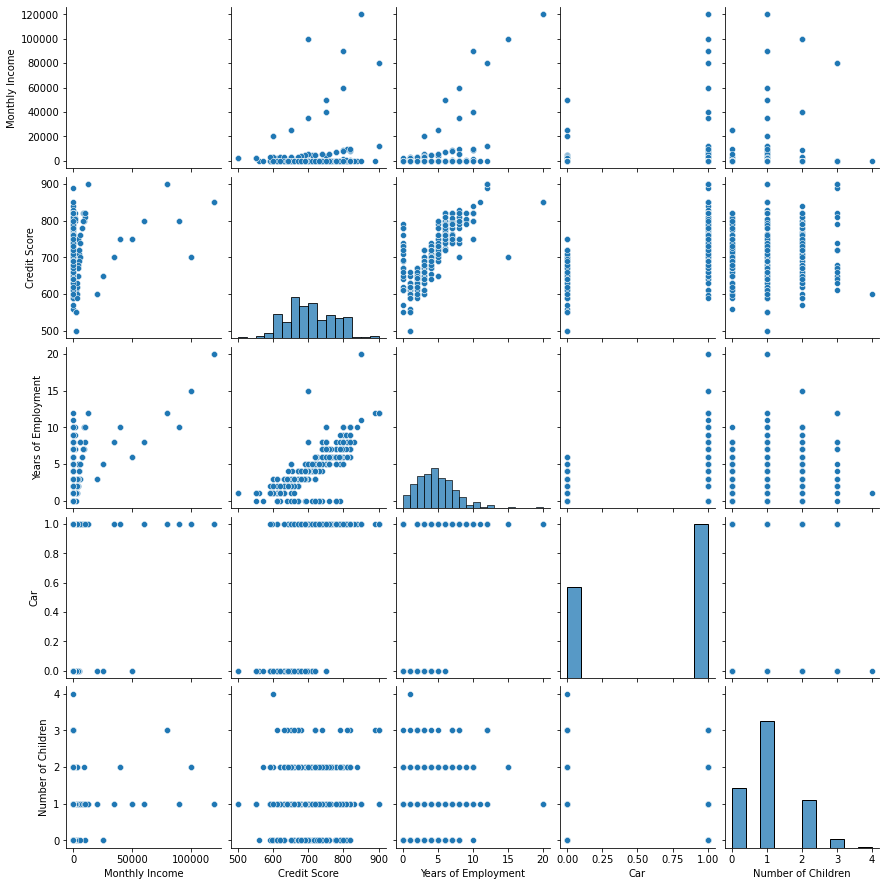

In [27]:
sns.pairplot(df_1[["Monthly Income","Credit Score","Years of Employment","Car","Number of Children"]])

<AxesSubplot:>

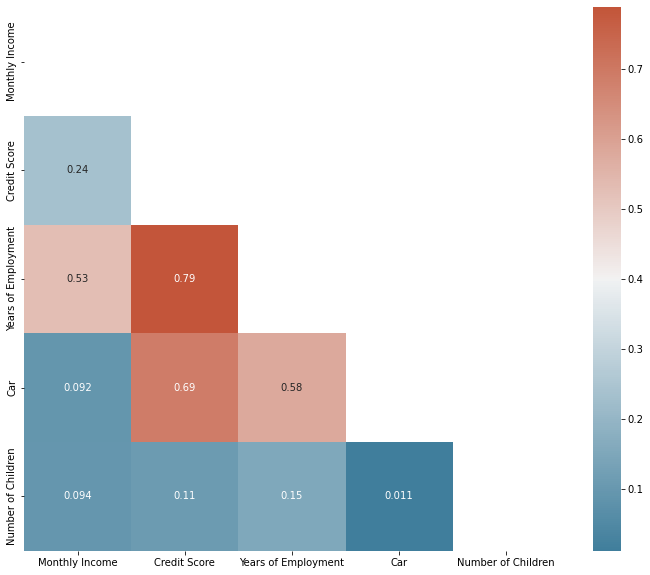

In [20]:
# Correlation between different variables
#
corr = df_1.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

## Ingeniería de Características:

Normalizamos las variables:

In [30]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

categorical_cols = ['Occupation', 'Finance Status', 'Finance History', 'Car']
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_1[col] = label_encoder.fit_transform(df_1[col])
    
df_1.head(10)

Occupation  Monthly Income  Credit Score  Years of Employment  \
0         107           40000         750.0                   10   
1          32           60000         800.0                    8   
2          74           25000         650.0                    5   
3          28           80000         900.0                   12   
4          12          100000         700.0                   15   
5          32           50000         750.0                    6   
6         107           35000         700.0                    8   
7          74           20000         600.0                    3   
8          12          120000         850.0                   20   
9          28           90000         800.0                   10   

   Finance Status  Finance History  Car  Number of Children  
0               2                5    1                   2  
1               2                5    1                   1  
2               1                3    0                   0  
3               0                5    1                   3  
4               2                3    1                   2  
5               1                5    0                   1  
6               1                3    1                   1  
7               3                3    0                   1  
8               0                5    1                   1  
9               2                5    1                   1

In [31]:
numerical_cols = ['Monthly Income', 'Credit Score', 'Years of Employment', 'Number of Children']
numerical_features = df_1[numerical_cols]

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_cols)

Scale numerical columns:

In [32]:
scaler = MinMaxScaler()
df_1[numerical_cols] = scaler.fit_transform(df_1[numerical_cols])

## Modelado Predictivo:

Usamos el metodo del codo para verificar el numero optimo de clusters:

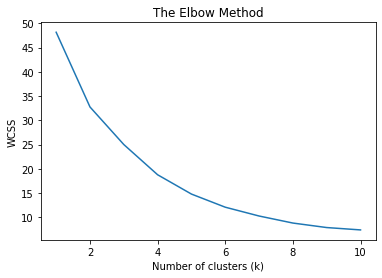

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
max_clusters = 10  # Maximum number of clusters to try

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [36]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df_1[numerical_cols])

KMeans(n_clusters=4, random_state=0)

In [38]:
df_1['Cluster'] = kmeans.labels_

## Interpretación del Modelo:

In [39]:
cluster_counts = df_1.groupby('Cluster')['Car'].value_counts()
print(cluster_counts)

Cluster  Car
0        0      140
         1       83
1        1      133
         0        4
2        1       74
         0       34
3        1       10
Name: Car, dtype: int64


In [40]:
inertia = kmeans.inertia_
silhouette = silhouette_score(df_1[numerical_cols], kmeans.labels_)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette)

Inertia: 18.792881789150943
Silhouette Score: 0.3692558892140319


In [66]:
# df_customer.to_csv("df_customer.csv", index=False, header=True)

## Visualización de Datos:

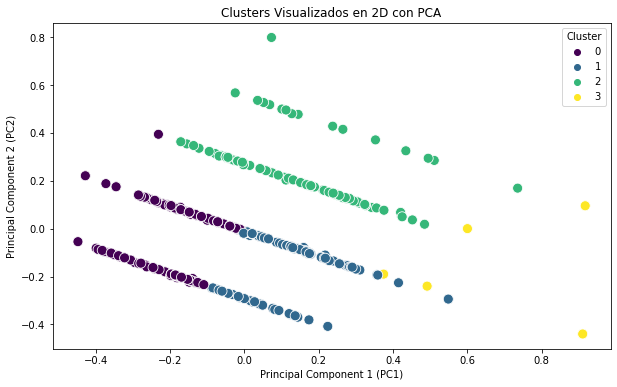

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Calcular la proyección PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_1[numerical_cols])

# Crear un DataFrame con las componentes principales y las etiquetas de los clusters
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_

# Visualizar los clusters en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=100)
plt.title('Clusters Visualizados en 2D con PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

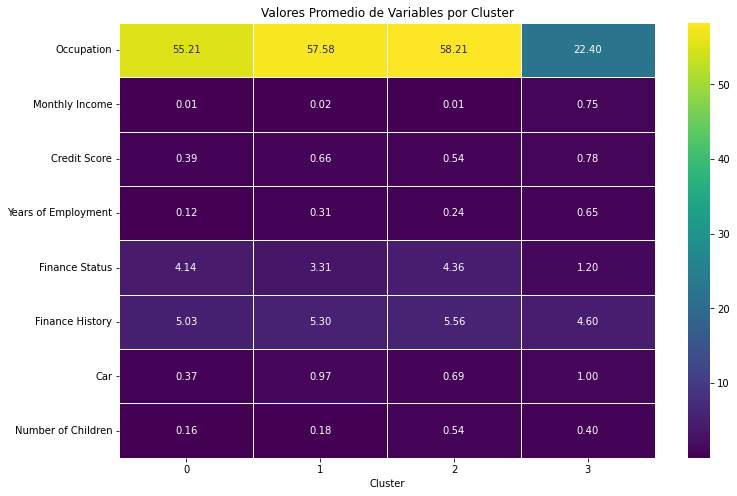

In [47]:
# Calcular los valores promedio de cada variable para cada cluster
cluster_means = df_1.groupby('Cluster').mean()

# Visualizar los resultados
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Valores Promedio de Variables por Cluster')
plt.show()

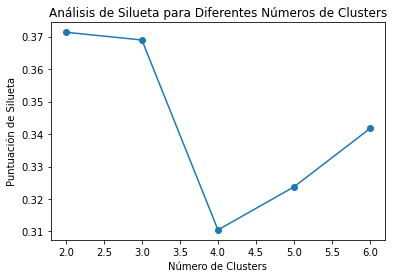

In [56]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Supongamos que ya tienes tu DataFrame df_1 con los datos y la columna 'Cluster'
# ...

# Seleccionar las variables numéricas para el análisis de silueta
numeric_cols = ['Monthly Income', 'Credit Score', 'Years of Employment', 'Number of Children']

# Escalar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_1[numeric_cols])

# Seleccionar el rango de número de clusters para probar
range_n_clusters = [2, 3, 4, 5, 6]

silhouette_scores = []

# Calcular el score de silueta para diferentes números de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Visualizar los resultados
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Análisis de Silueta para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta')
plt.show()


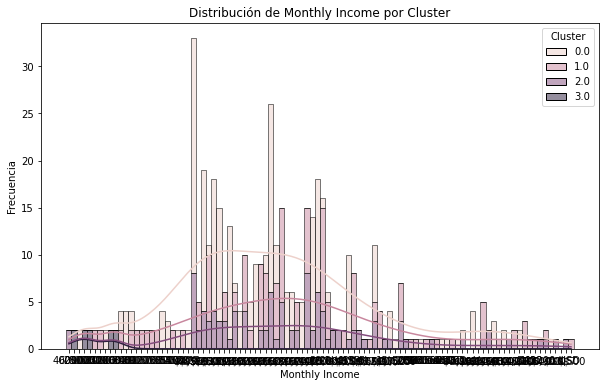

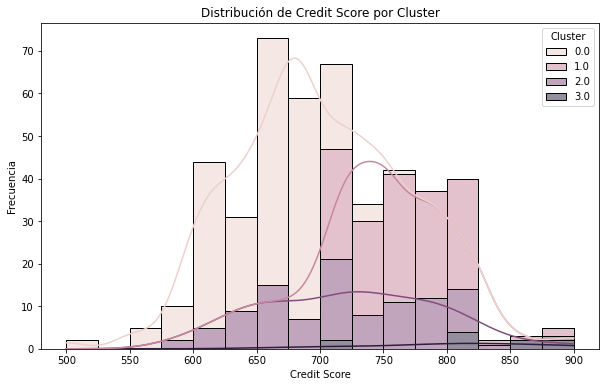

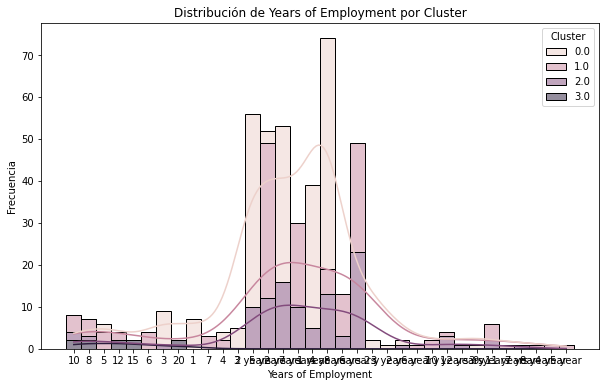

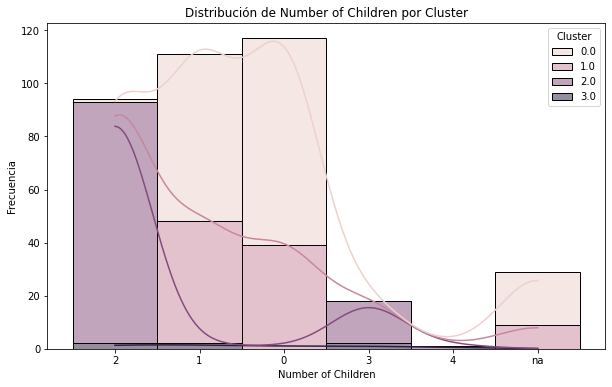

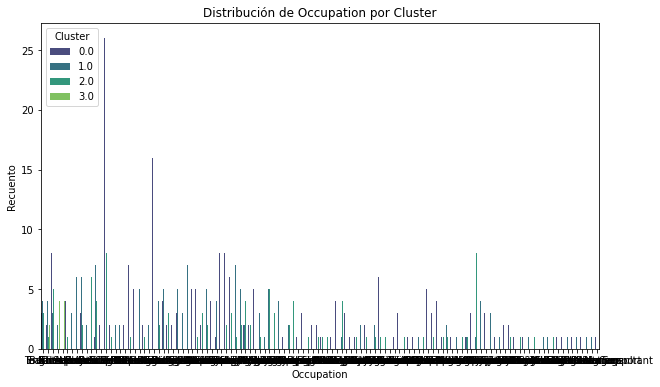

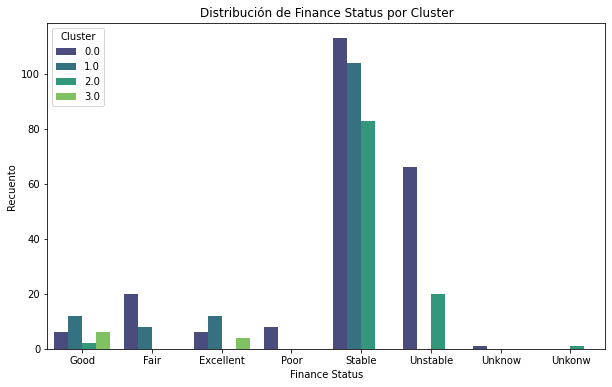

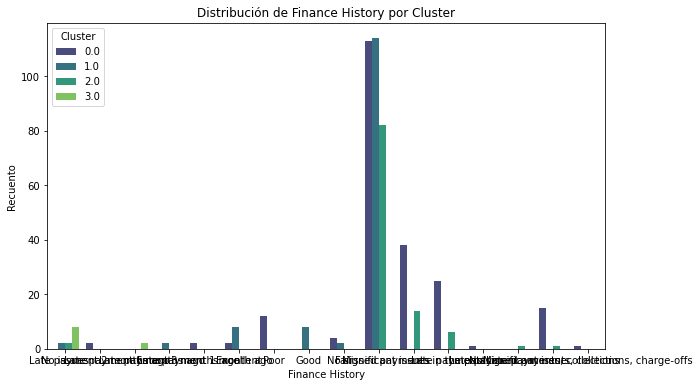

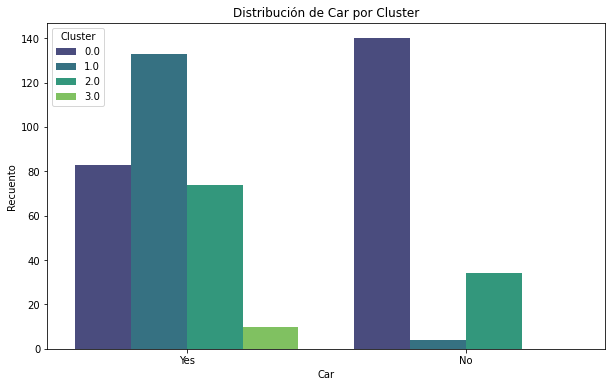

In [54]:
df_customer['Cluster'] = df_1['Cluster']
# Gráficos de variables numéricas
numeric_cols = ['Monthly Income', 'Credit Score', 'Years of Employment', 'Number of Children']

for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_customer, x=col, hue='Cluster', multiple="stack", kde=True)
    plt.title(f'Distribución de {col} por Cluster')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Gráficos de variables categóricas
categorical_cols = ['Occupation', 'Finance Status', 'Finance History', 'Car']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_customer, x=col, hue='Cluster', palette='viridis')
    plt.title(f'Distribución de {col} por Cluster')
    plt.xlabel(col)
    plt.ylabel('Recuento')
    plt.show()


**Grupo 3**: Altos ingresos y crédito excelente.

**Grupo 1**: Ingresos medios y crédito bueno.

**Grupo 2**: Ingresos bajos y crédito regular.
 
**Grupo 0**: Ingresos muy bajos y crédito malo.

Por lo tanto, las personas en el grupo 3 son las que tienen el mejor perfil, ya que tienen altos ingresos y un crédito excelente. Las personas en el grupo 0 son las que tienen el nivel más bajo, ya que tienen ingresos muy bajos y un crédito malo.

## Recomendaciones de Negocio:

### Recomendaciones de Negocio basadas en Grupos de Clientes

#### Grupo 3: Altos ingresos y crédito excelente
Las personas en este grupo tienen un perfil financiero excelente, con altos ingresos y una calificación crediticia destacada. Se recomienda ofrecer productos financieros premium, como tarjetas de crédito con beneficios exclusivos, inversiones de alto rendimiento y servicios personalizados. Además, es una oportunidad para promover ofertas exclusivas y programas de lealtad.

#### Grupo 1: Ingresos medios y crédito bueno
Este grupo representa a clientes con ingresos medios y una calificación crediticia buena. Se puede orientar a estos clientes hacia productos financieros que se adapten a su nivel de ingresos y necesidades, como préstamos personales, tarjetas de crédito con tasas competitivas y servicios de planificación financiera. Es crucial ofrecerles opciones atractivas que mejoren su lealtad.

#### Grupo 2: Ingresos bajos y crédito regular
Clientes en este grupo tienen ingresos bajos y una calificación crediticia regular. Se podría considerar la oferta de productos diseñados para mejorar su situación crediticia, como programas de educación financiera, préstamos con tasas preferenciales para clientes leales y opciones de ahorro accesibles. Establecer relaciones a largo plazo podría ser clave para mejorar su situación financiera.

#### Grupo 0: Ingresos muy bajos y crédito malo
Este grupo presenta el mayor desafío financiero, con ingresos muy bajos y una calificación crediticia deficiente. Las estrategias podrían incluir programas de asesoramiento financiero, productos de ahorro específicos para clientes en situaciones difíciles y soluciones de préstamos adaptadas a su capacidad de pago. También se podría explorar iniciativas de responsabilidad social corporativa para apoyar a esta comunidad.

En resumen, personalizar las ofertas y servicios según los perfiles de los grupos permitirá una estrategia más efectiva y satisfactoria para los clientes, al tiempo que contribuirá al crecimiento y la sostenibilidad del negocio.


## Presentación de Resultados:

Presentacion de resultados en streamlit

# DF2

## Comprensión del Negocio y de los Datos:

### Identificación de objetivos de negocio y traducción en objetivos de análisis de datos:

##### Definición del problema desde el negocio:

    1. Debemos predecir el precio de un vehiculo dadas sus diferentes caracteristicas.

##### En que se va a usar la solucion?:

    2. Se va a recomendar un precio de cada vehiculo, dado un historial de diferentes caracteristicas.

##### Como es el enfoque del problema(supervisado/no-supervisado/semi-supervisado)?:

    3. En ésta base de datos tenemos la columna "Price" con la que podremos hacer modelos supervisados.

##### Como podemos medir el problema?:

    4. Podemos usar medidas como: RMSE.


In [91]:
df_2 = df_cars.copy()

### Exploración inicial de los datos para entender sus características y calidad.

In [7]:
df_2.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [8]:
df_cars.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

## Limpieza y Preprocesamiento de Datos:

### Identificación y manejo de valores faltantes.

In [9]:
def clean_df_cars(df):
    df = df.drop_duplicates(keep=False)
    ## Limpiar Levy
    df.Levy = df.Levy.apply(lambda x : str(x).replace("-","0"))
    df.Levy = df.Levy.apply(lambda x : int(x))
    ## Limpiar Mileage 
    df.Mileage = df.Mileage.apply(lambda x : str(x).replace("km"," "))
    df.Mileage = df.Mileage.apply(lambda x : int(x))
    ## Limpiar Doors
    df.Doors = df.Doors.apply(lambda x : str(x).replace("04-May","4-5"))
    df.Doors = df.Doors.apply(lambda x : str(x).replace("02-Mar","2-3"))
    ## Limpiar Engine
    df['Engine volume'] = df['Engine volume'].apply(lambda x : str(x).replace("Turbo"," "))
    df['Engine volume'] = df['Engine volume'].apply(lambda x : float(x))
    return df


In [92]:
df_2= clean_df_cars(df_2)

c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2073414333.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Engine volume'] = df['Engine volume'].apply(lambda x : str(x).replace("Turbo"," "))
C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2073414333.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [29]:
df_2.head(5)

ID  Levy Manufacturer     Model  Prod. year   Category  \
0  45654403  1399        LEXUS    RX 450        2010       Jeep   
2  45774419     0        HONDA       FIT        2006  Hatchback   
3  45769185   862         FORD    Escape        2011       Jeep   
4  45809263   446        HONDA       FIT        2014  Hatchback   
5  45802912   891      HYUNDAI  Santa FE        2016       Jeep   

  Leather interior Fuel type  Engine volume  Mileage  Cylinders Gear box type  \
0              Yes    Hybrid            3.5   186005        6.0     Automatic   
2               No    Petrol            1.3   200000        4.0      Variator   
3              Yes    Hybrid            2.5   168966        4.0     Automatic   
4              Yes    Petrol            1.3    91901        4.0     Automatic   
5              Yes    Diesel            2.0   160931        4.0     Automatic   

  Drive wheels Doors             Wheel   Color  Airbags  
0          4x4   4-5        Left wheel  Silver       12  
2        Front   4-5  Right-hand drive   Black        2  
3          4x4   4-5        Left wheel   White        0  
4        Front   4-5        Left wheel  Silver        4  
5        Front   4-5        Left wheel   White        4

### Tratamiento de outliers y datos atípicos.

In [107]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Copiar el DataFrame para no modificar el original
df_cleaned = df_2.copy()

# Entrenar un modelo de Isolation Forest para identificar outliers en el precio por cada fabricante
clf = IsolationForest(contamination=0.05, random_state=42)

# Crear una columna 'outlier' para cada fabricante
df_cleaned['outlier'] = df_cleaned.groupby('Manufacturer')['Price'].transform(lambda x: clf.fit_predict(x.values.reshape(-1, 1)))

# Filtrar las filas que no son outliers
df_cleaned = df_cleaned[df_cleaned['outlier'] != -1]

# Eliminar la columna 'outlier' que se usó temporalmente
df_cleaned = df_cleaned.drop('outlier', axis=1)

# Restablecer el índice
df_cleaned.reset_index(drop=True, inplace=True)

# Visualizar el DataFrame limpio
df_cleaned.head()


ID  Price  Levy Manufacturer     Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS    RX 450        2010       Jeep   
1  45774419   8467     0        HONDA       FIT        2006  Hatchback   
2  45769185   3607   862         FORD    Escape        2011       Jeep   
3  45809263  11726   446        HONDA       FIT        2014  Hatchback   
4  45802912  39493   891      HYUNDAI  Santa FE        2016       Jeep   

  Leather interior Fuel type  Engine volume  Mileage  Cylinders Gear box type  \
0              Yes    Hybrid            3.5   186005        6.0     Automatic   
1               No    Petrol            1.3   200000        4.0      Variator   
2              Yes    Hybrid            2.5   168966        4.0     Automatic   
3              Yes    Petrol            1.3    91901        4.0     Automatic   
4              Yes    Diesel            2.0   160931        4.0     Automatic   

  Drive wheels Doors             Wheel   Color  Airbags  
0          4x4   4-5        Left wheel  Silver       12  
1        Front   4-5  Right-hand drive   Black        2  
2          4x4   4-5        Left wheel   White        0  
3        Front   4-5        Left wheel  Silver        4  
4        Front   4-5        Left wheel   White        4

### Transformación de variables si es necesario.

En este caso no transformamos variables.

## Análisis Exploratorio de Datos (EDA):

### Analisis univariado

Fuel type:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Fuel type', ylabel='Number of Cars'>)

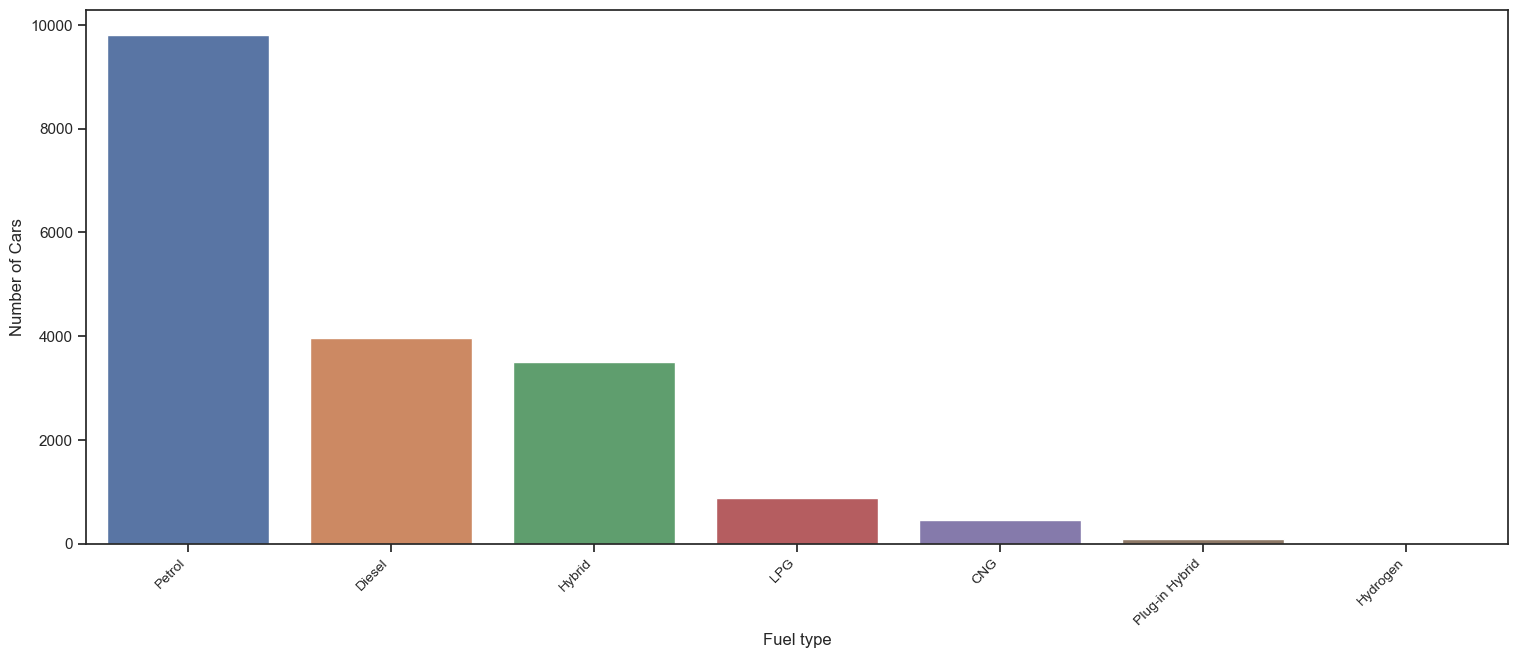

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_analysis(df, var):

    fuel_counts = df[var].value_counts()

    fig, ax = plt.subplots(figsize=(15,6))
    plt.tight_layout(pad=1)

    ax.set_xticklabels(fuel_counts.index, rotation=45)

    sns.barplot(x=fuel_counts.index, y=fuel_counts, ax=ax)

    ax.set_xticklabels(fuel_counts.index, rotation=45, ha='right')

    # Reducir tamaño de fuente 
    ax.tick_params(axis='x', labelsize=10)

    ax.set(xlabel=var, ylabel='Number of Cars')
    
    return fig, ax

var = 'Fuel type' 

plot_analysis(df_2, var)

Gear box:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Gear box type', ylabel='Number of Cars'>)

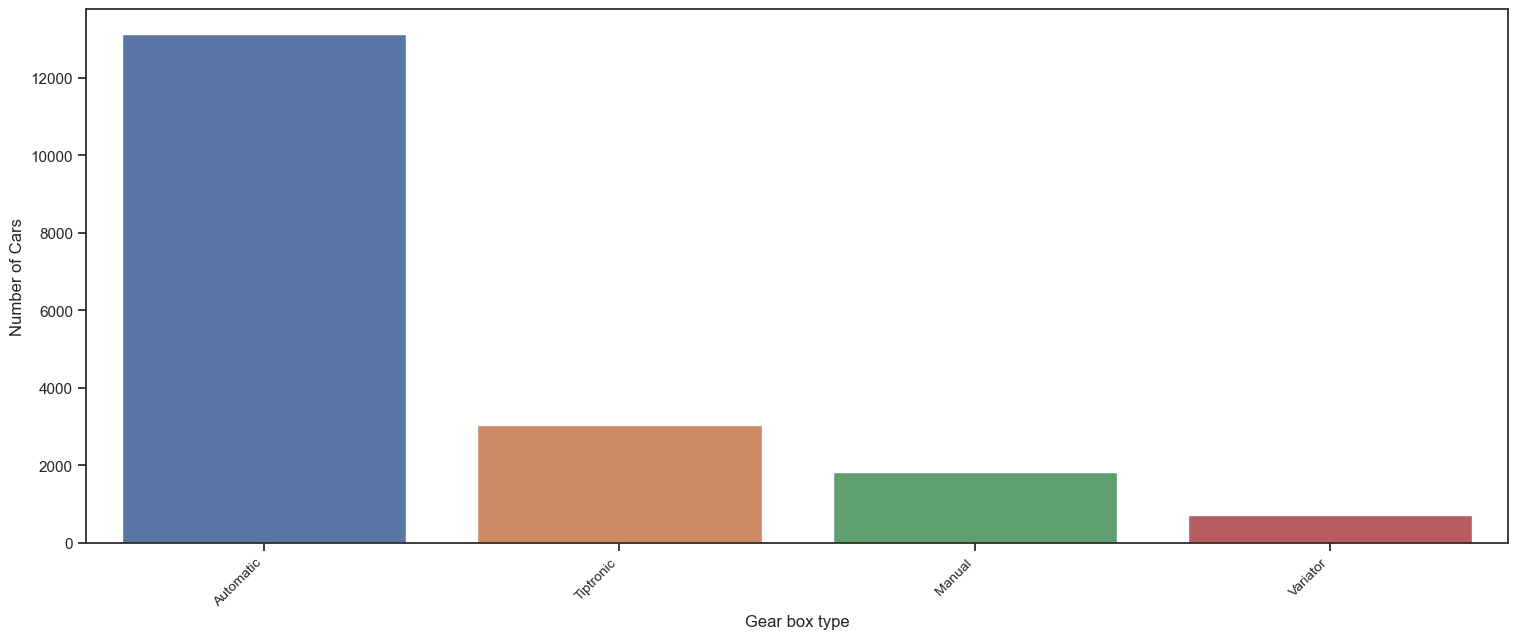

In [59]:
plot_analysis(df_2,"Gear box type")

Manufacturer

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Manufacturer', ylabel='Number of Cars'>)

c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 4321 (\N{GEORGIAN LETTER SAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 4334 (\N{GEORGIAN LETTER XAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 4309 (\N{GEORGIAN LETTER VIN}) missing from current font.
  func(*args, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 4304 (\N{GEORGIAN LETTER AN}) missing from current font.
  func(*args, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4321 (\N{GEORGIAN LETTER SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mfarias\AppData\Local\anaconda3\li

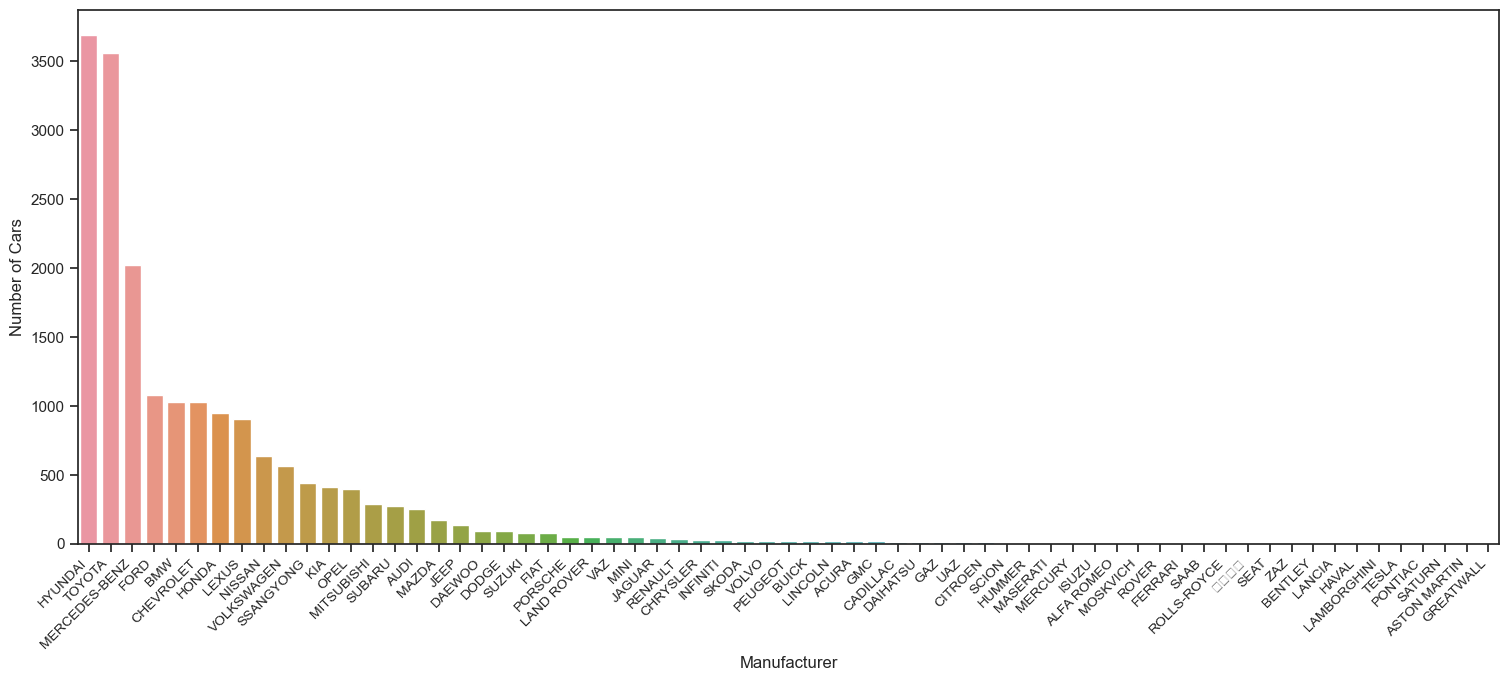

In [60]:
plot_analysis(df_2,"Manufacturer")

Category:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Category', ylabel='Number of Cars'>)

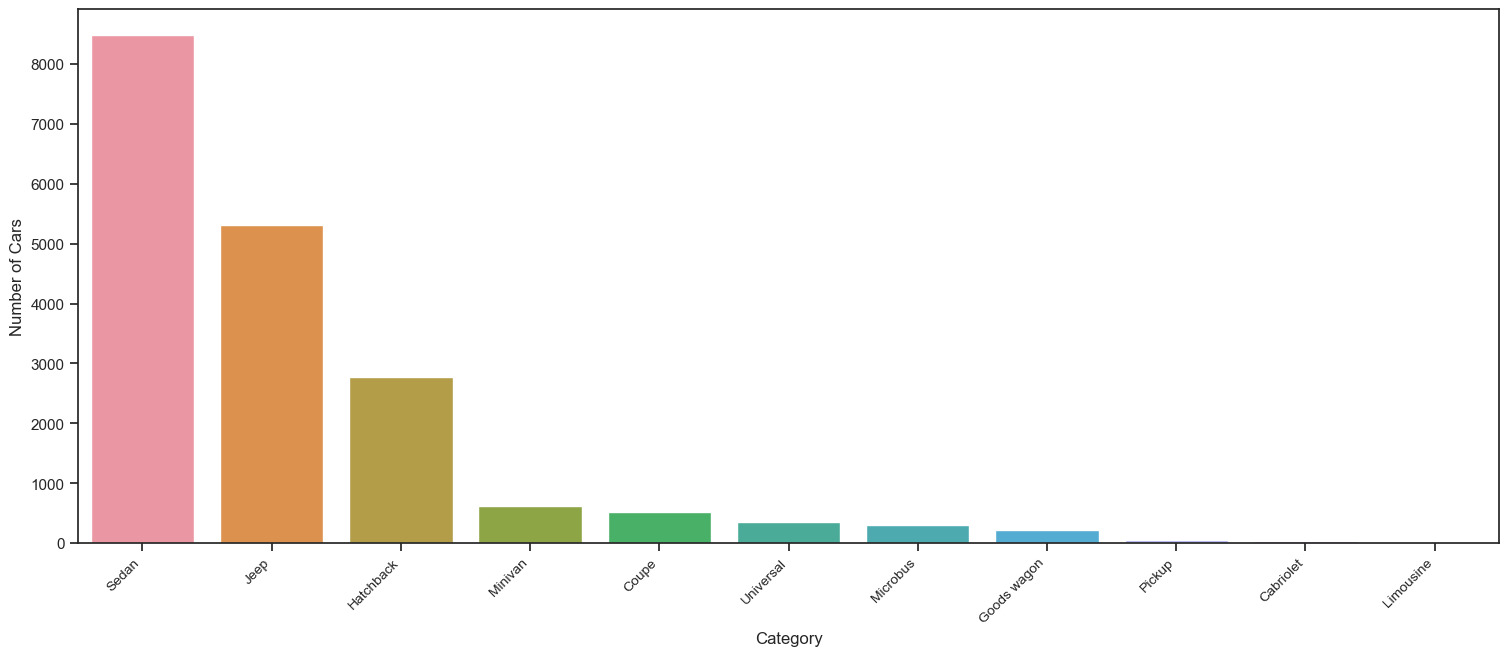

In [62]:
plot_analysis(df_2,"Category")

Prod. year:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Prod. year', ylabel='Number of Cars'>)

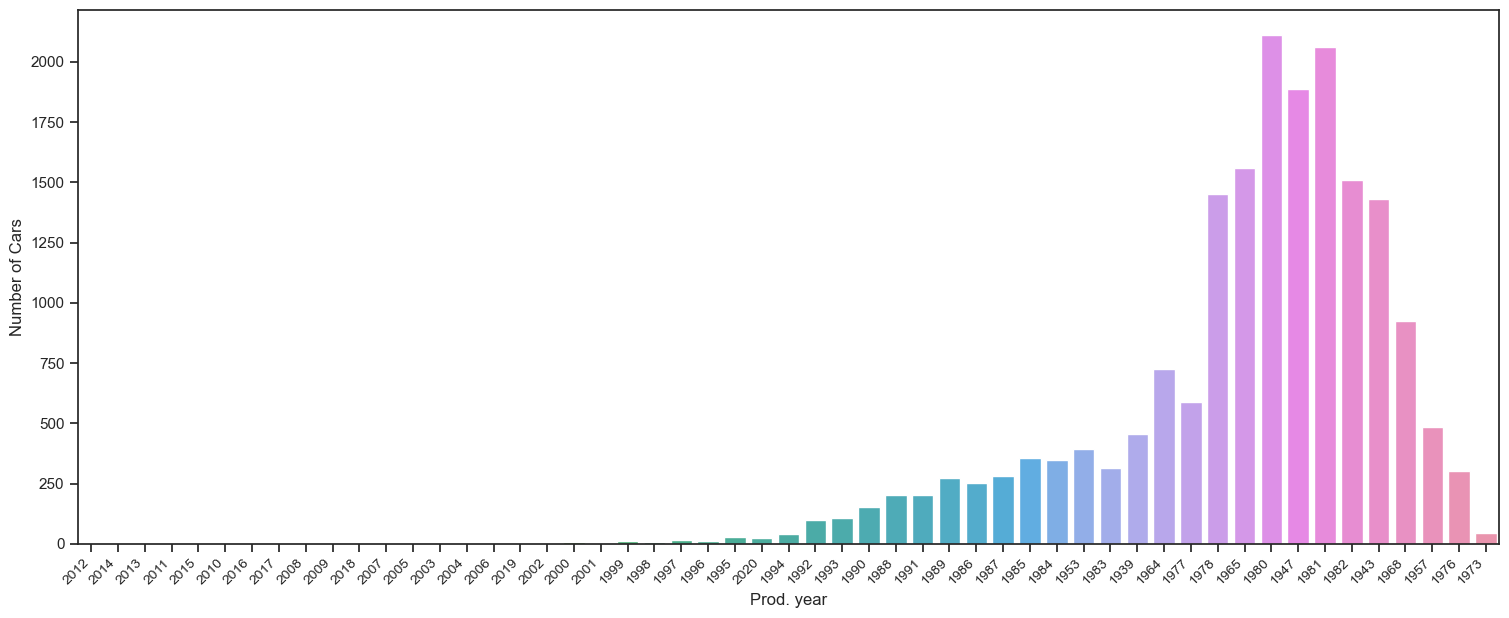

In [63]:
plot_analysis(df_2,"Prod. year")

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Engine volume', ylabel='Number of Cars'>)

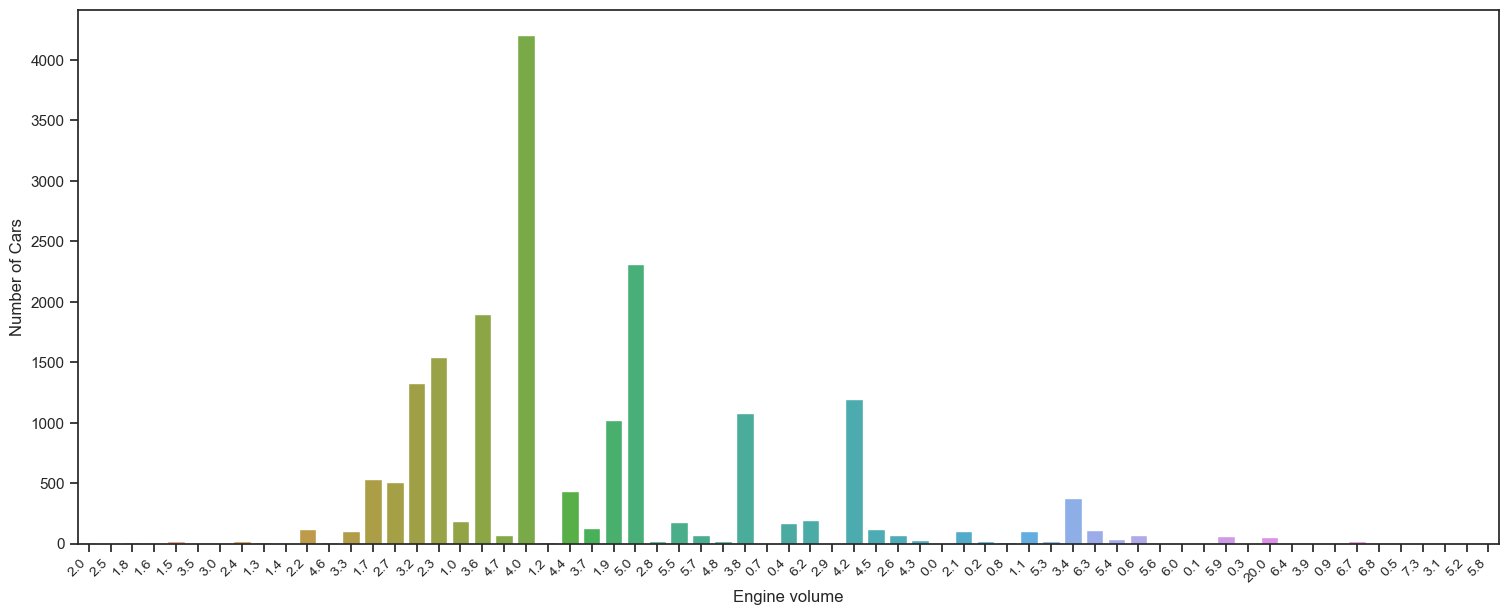

In [64]:
plot_analysis(df_2,"Engine volume")

Cylinders:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Cylinders', ylabel='Number of Cars'>)

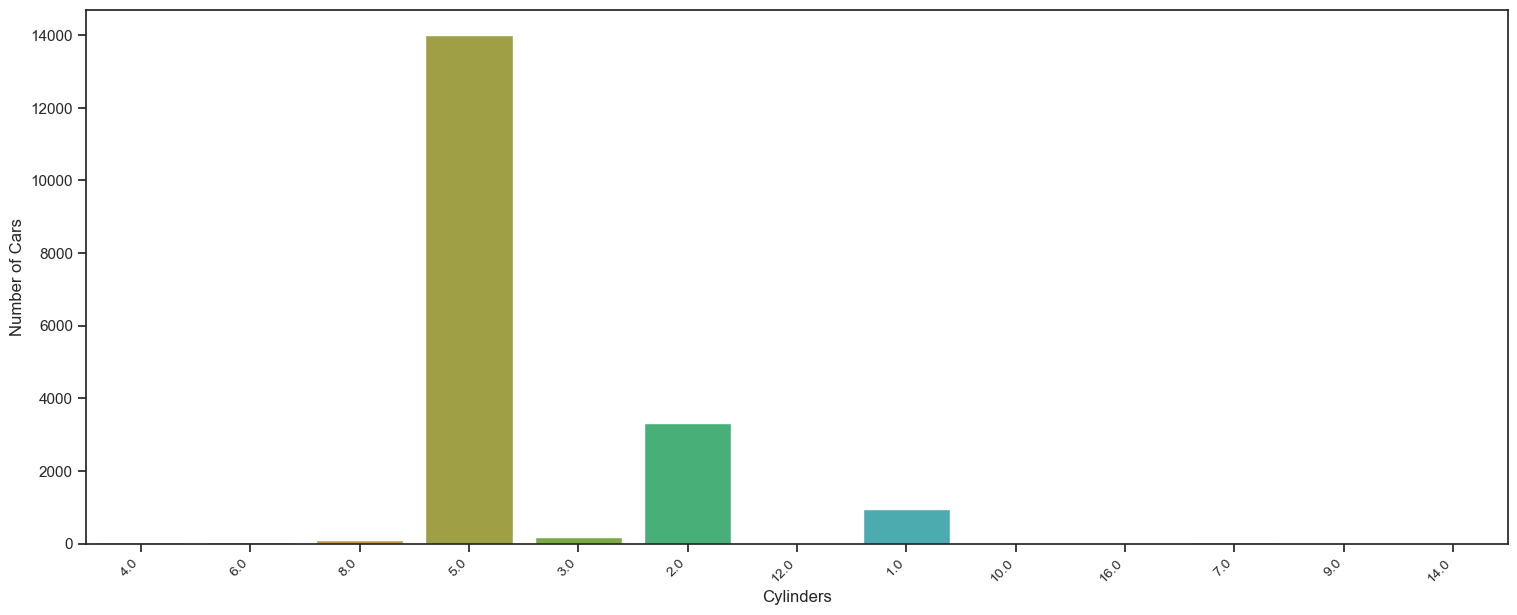

In [65]:
plot_analysis(df_2,"Cylinders")

Mileage:

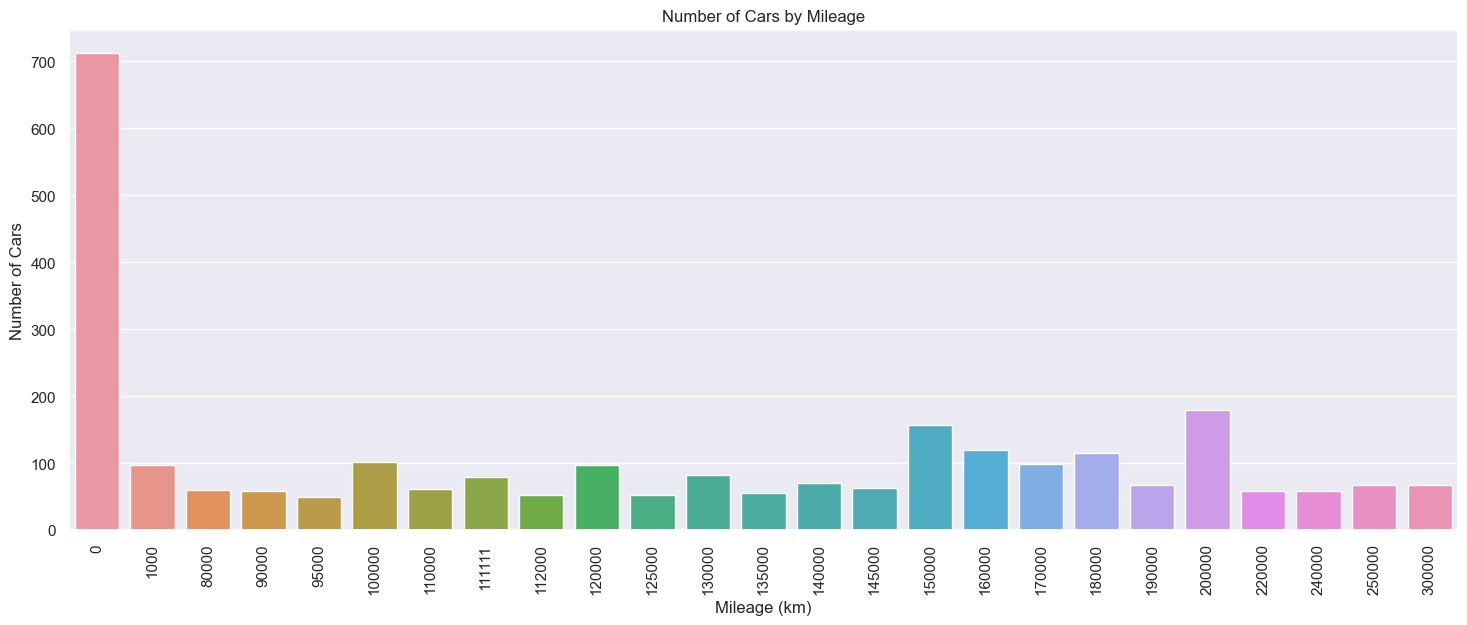

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener conteos
mileage_counts = df_2['Mileage'].value_counts().head(25)

# Crear gráfica
fig, ax = plt.subplots(figsize=(15, 6))
plt.tight_layout(pad=2)

# Gráfica de barras
sns.barplot(x=mileage_counts.index, y=mileage_counts, ax=ax)

# Formatear ejes
ax.set_xticklabels(mileage_counts.index, rotation=90) 
ax.set(xlabel='Mileage (km)', ylabel='Number of Cars')
ax.set_title('Number of Cars by Mileage')
ax.set_xticklabels(mileage_counts.index.sort_values(), rotation=90)
plt.show()

Airbag:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Airbags', ylabel='Number of Cars'>)

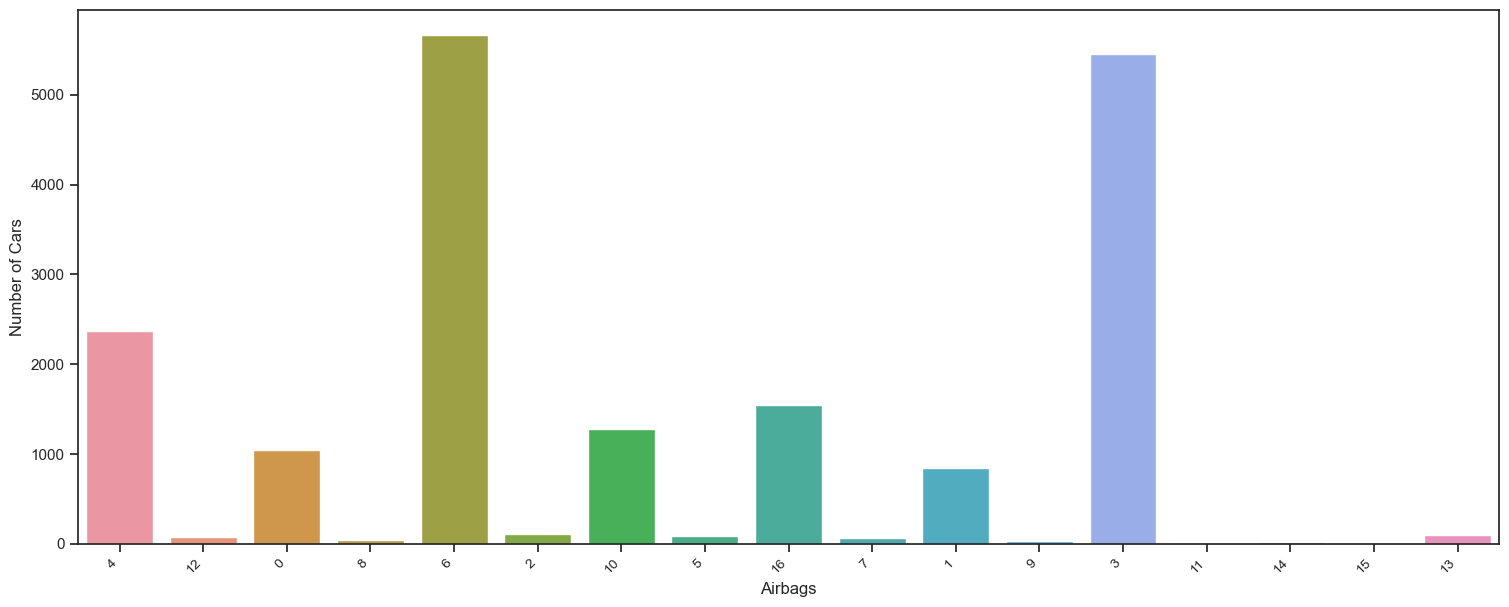

In [67]:
plot_analysis(df_2,"Airbags")

Color:

C:\Users\mfarias\AppData\Local\Temp\ipykernel_19392\2185065127.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(fuel_counts.index, rotation=45)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: xlabel='Color', ylabel='Number of Cars'>)

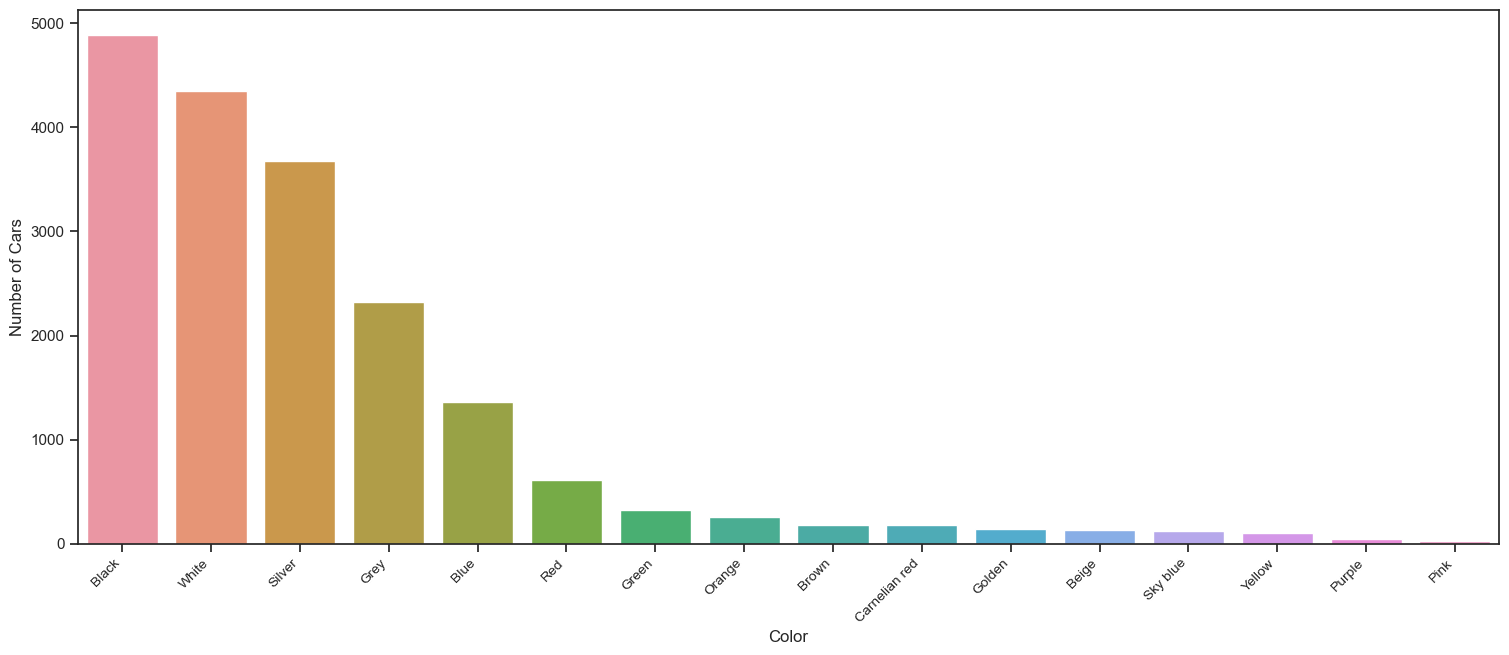

In [68]:
plot_analysis(df_2,"Color")

### Multivariado:

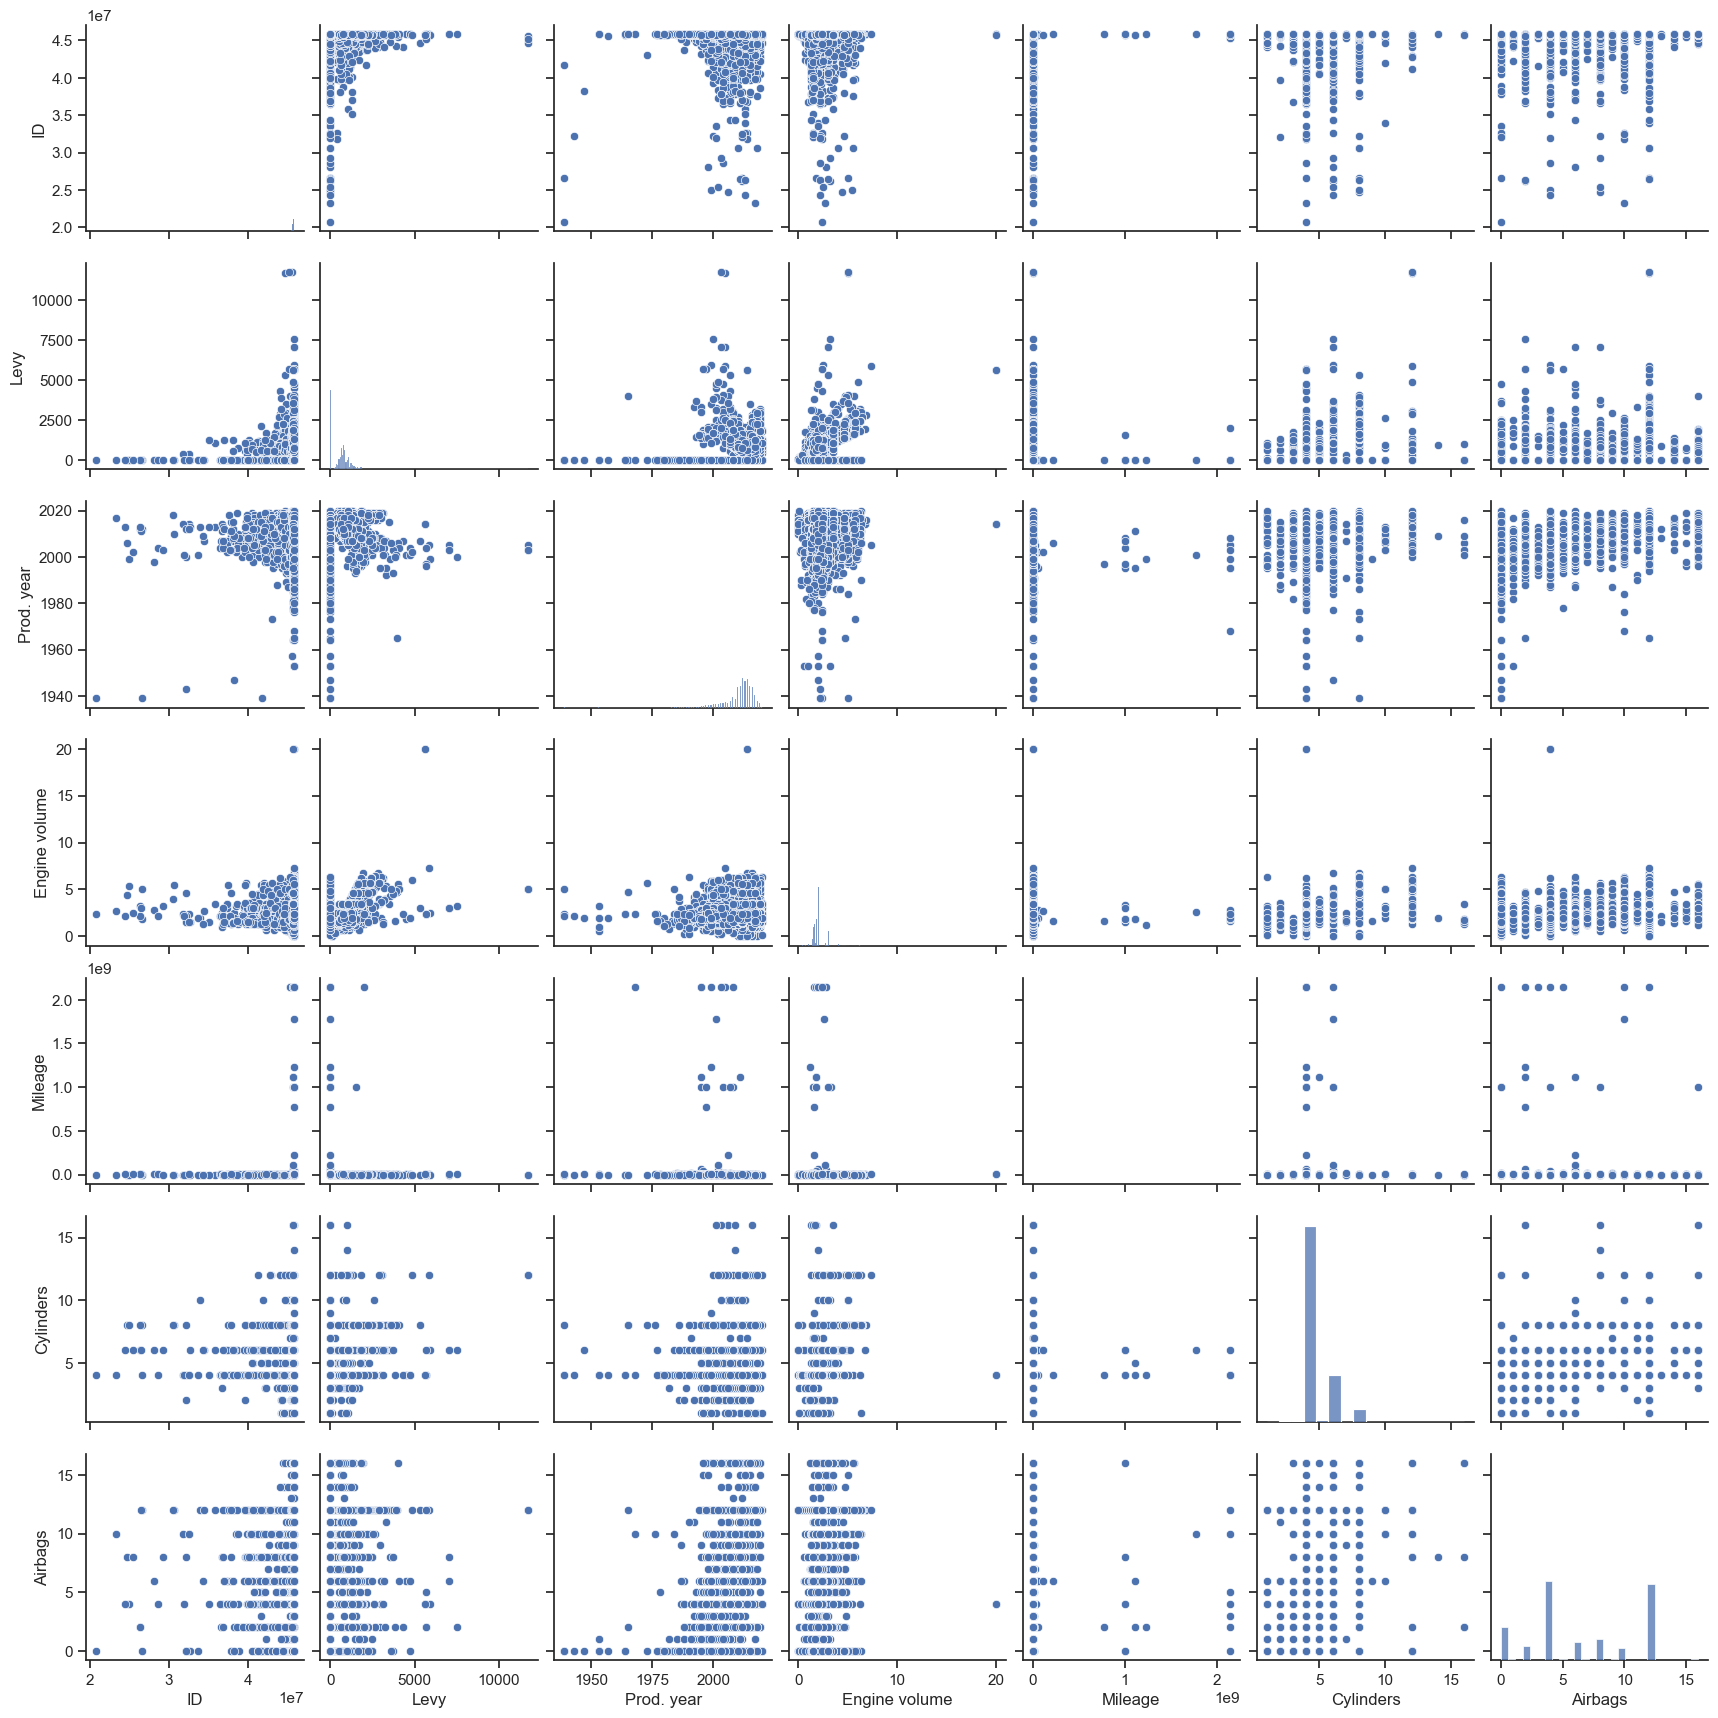

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

def numeric_columns_for_pairplot(df):
    """
    Selecciona las columnas numéricas de un DataFrame para hacer un pairplot.

    Args:
        df (pd.DataFrame): DataFrame de entrada.

    Returns:
        pd.DataFrame: DataFrame que contiene solo las columnas numéricas.
    """
    numeric_columns = df.select_dtypes(include=['number'])
    return numeric_columns

# Ejemplo de uso
# Supongamos que df es tu DataFrame
df_numeric = numeric_columns_for_pairplot(df_2)

# Realizar pairplot
sns.pairplot(df_numeric)
plt.show()

c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\mfarias\AppData\Local\anaconda3

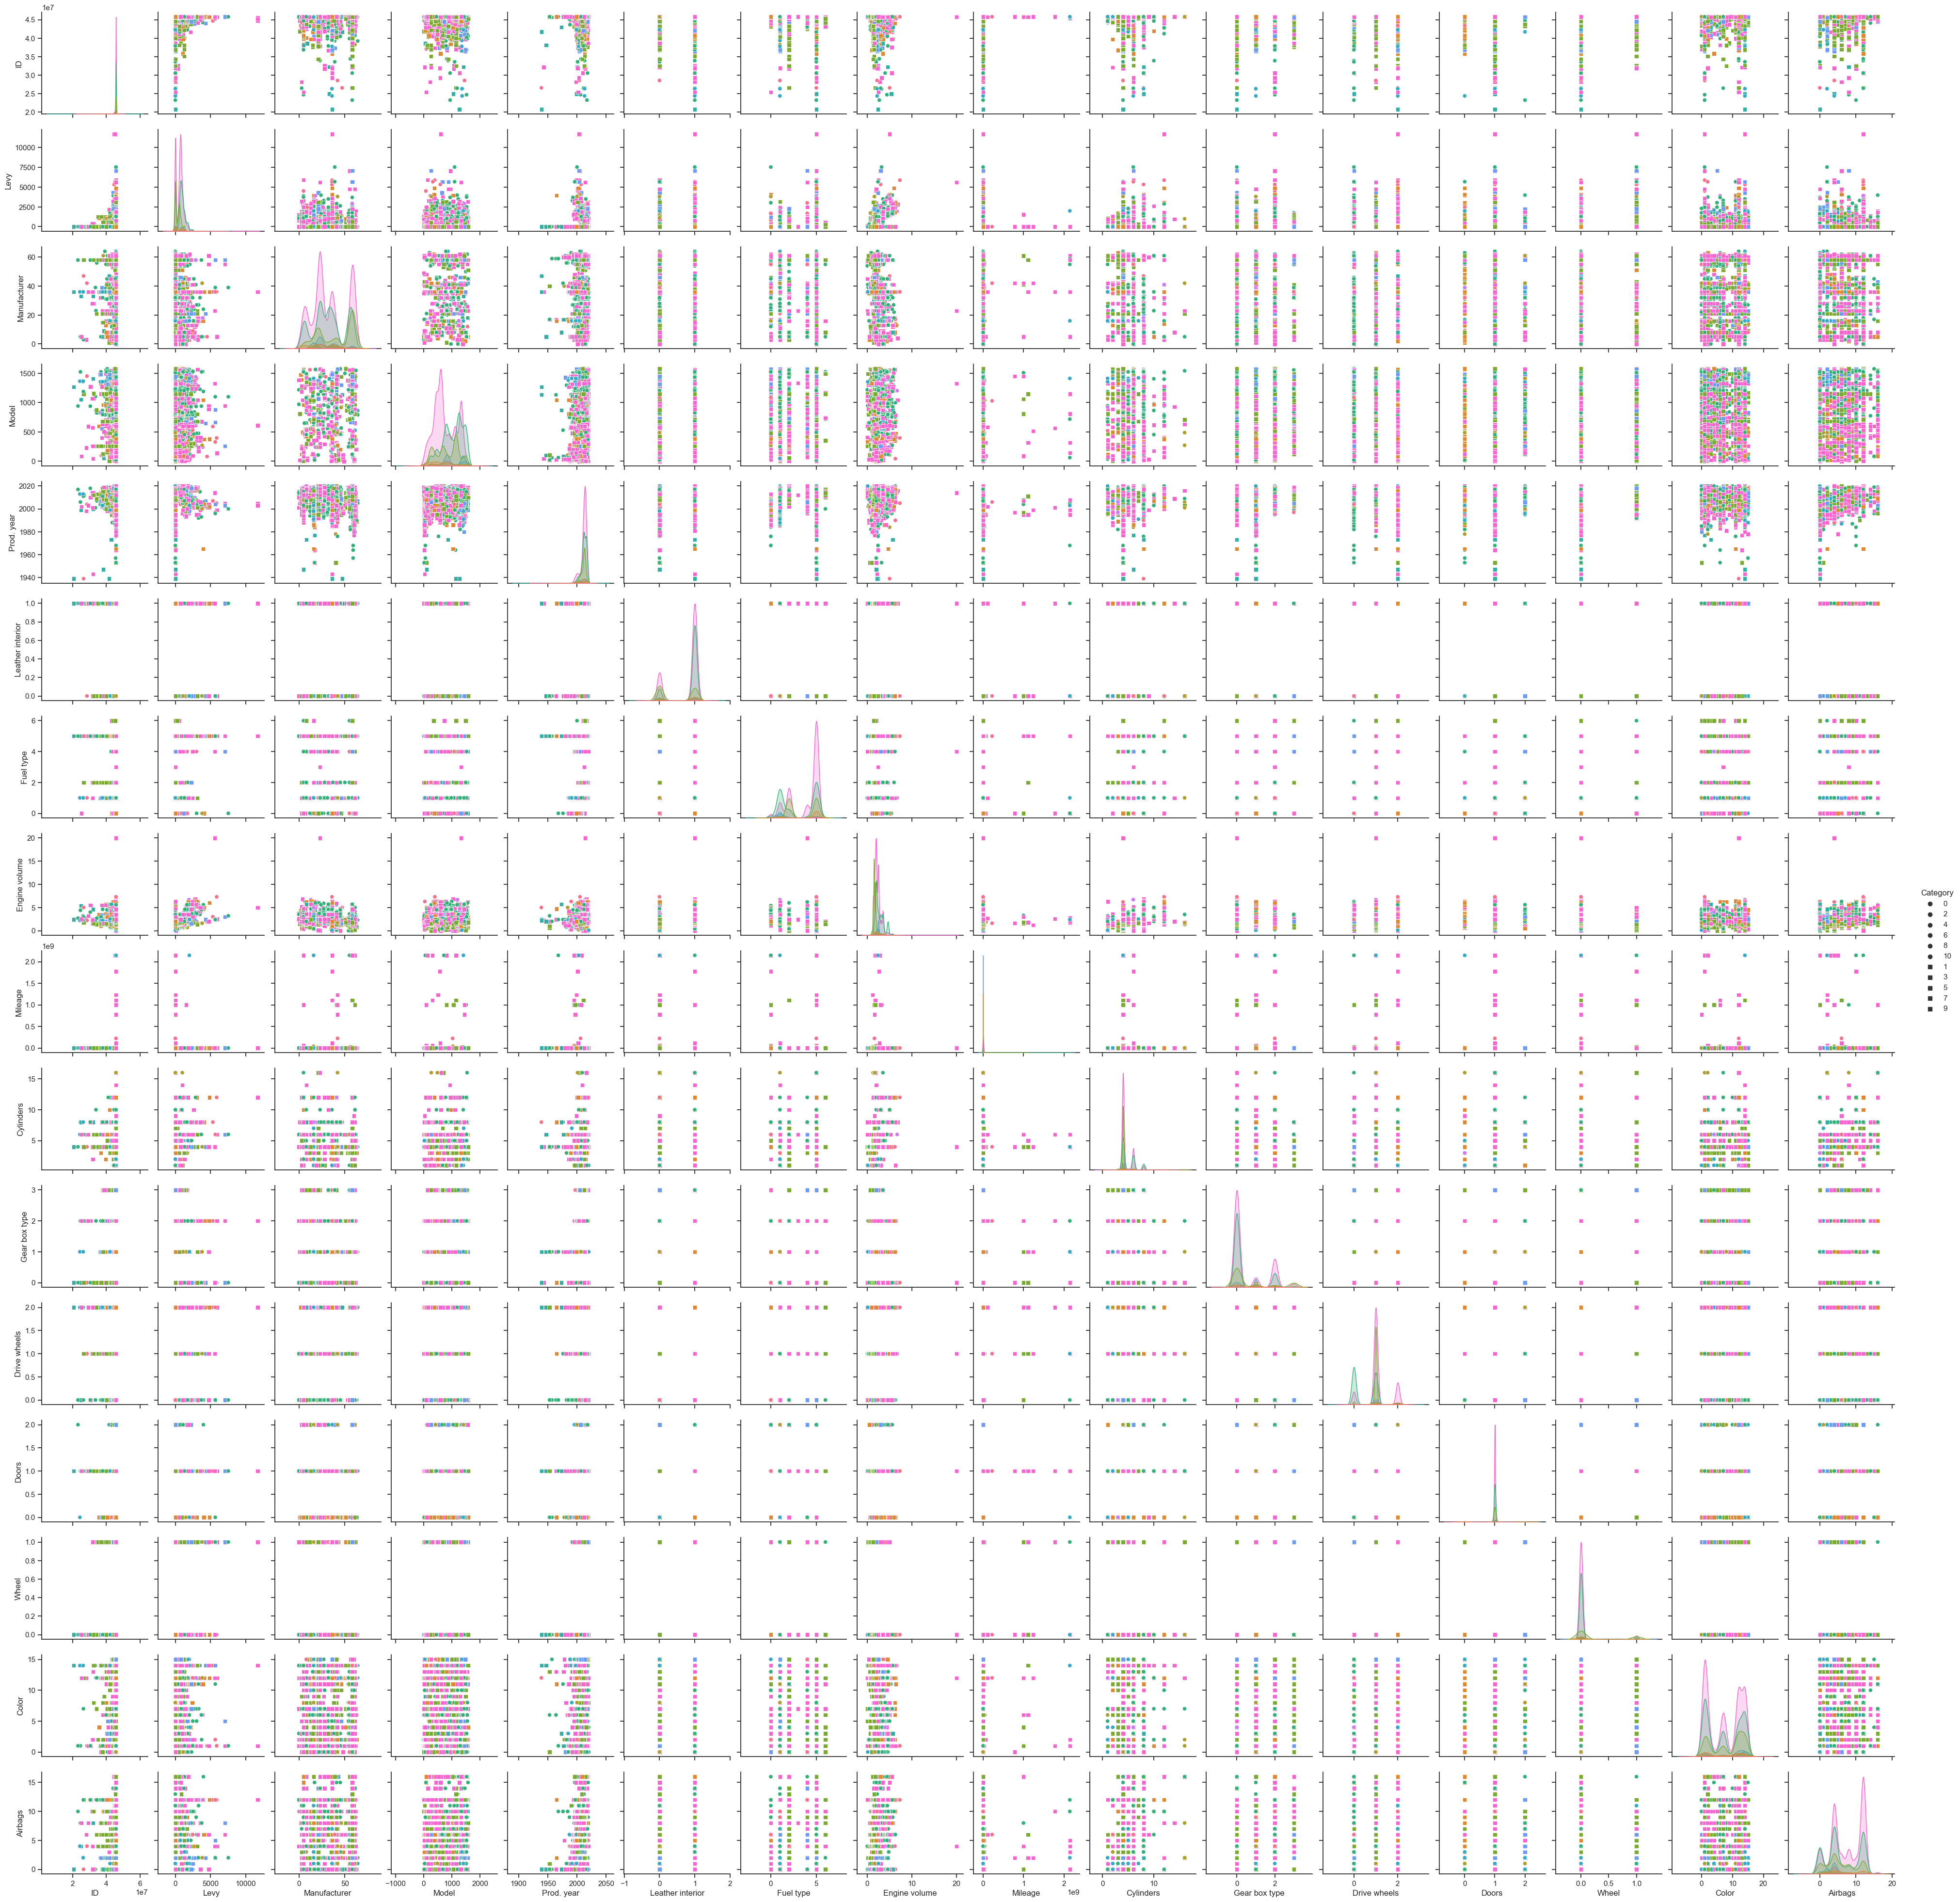

In [78]:

# Mapear las columnas categóricas a valores numéricos
df_non_numeric = df_2.copy()
for col in df_2.select_dtypes(include='object').columns:
    df_non_numeric[col] = df_2[col].astype('category').cat.codes

# Crear un pairplot con variables categóricas
sns.set(style="ticks")
sns.pairplot(df_non_numeric, hue="Category", palette="husl", markers=["o", "s"])
plt.show()

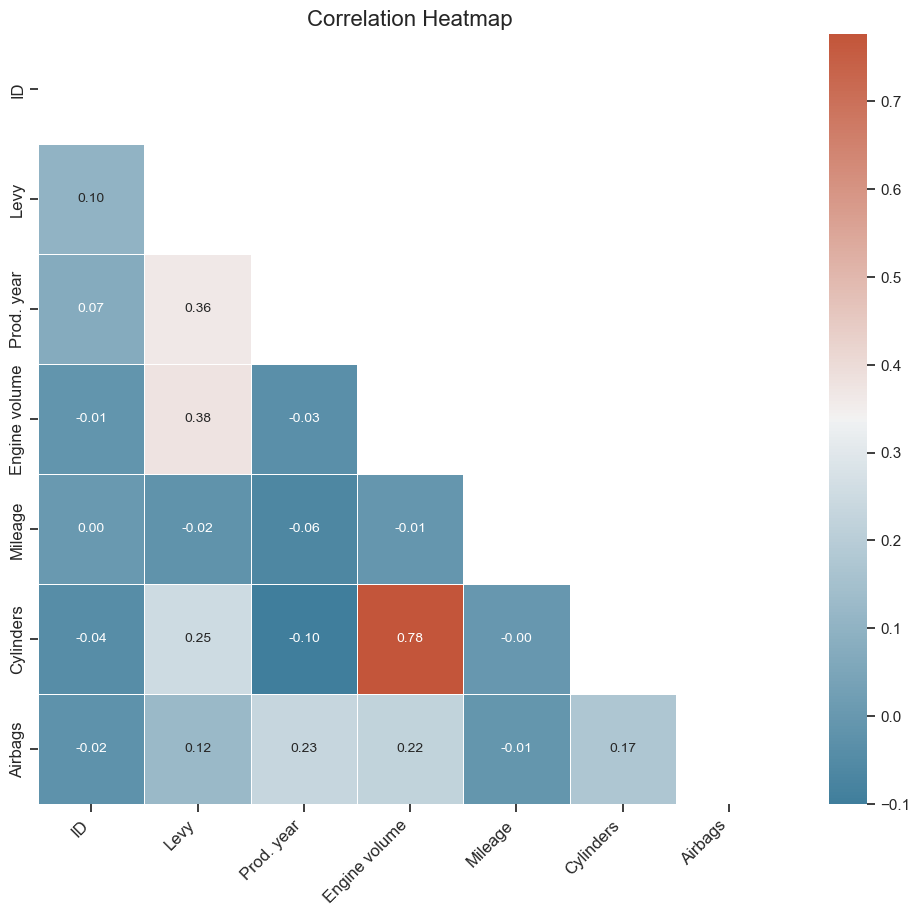

In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation between different variables
corr = df_numeric.corr()

# Set up the matplotlib plot configuration
plt.figure(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, linewidths=.5, fmt=".2f", annot_kws={"size": 10})

# Customize the plot
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


### Identificación de patrones, correlaciones y variables significativas.

Las variables que podemos quitar dado que no son significativas son: ID, Levy,  Cylinders (dado que se relaciona con Engine volume).

In [120]:
# Eliminar columnas no deseadas
df_2_filtered = df_cleaned.drop(['ID', 'Levy', 'Cylinders'], axis=1)

## Ingeniería de Características:

### Creación de nuevas variables significativas.
No es necesario en éste caso.

### Selección de características relevantes para el modelado.

now we remove the outliers on prices:

In [121]:
# Manejar variables categóricas
df_2_encoded = pd.get_dummies(df_2_filtered)


In [147]:
df_2.head(2)

ID  Price  Levy Manufacturer   Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS  RX 450        2010       Jeep   
2  45774419   8467     0        HONDA     FIT        2006  Hatchback   

  Leather interior Fuel type  Engine volume  Mileage  Cylinders Gear box type  \
0              Yes    Hybrid            3.5   186005        6.0     Automatic   
2               No    Petrol            1.3   200000        4.0      Variator   

  Drive wheels Doors             Wheel   Color  Airbags  
0          4x4   4-5        Left wheel  Silver       12  
2        Front   4-5  Right-hand drive   Black        2

## Modelado Predictivo:

### Elección de modelos apropiados para cada conjunto de datos.

Random Forest, LightGBM,
KNN Regresión,
SVM,
Redes Neuronales Artificiales,
Redes Neuronales Convolucionales,
ARIMA

### Entrenamiento y evaluación de modelos utilizando métricas apropiadas.

La metrica de medición que usaremos es el RMSE.

### Optimización de hiperparámetros y validación cruzada.


#### Random Forest:

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo de Random Forest
rf = RandomForestRegressor(random_state=42)

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Crear y entrenar el modelo de Random Forest con los mejores hiperparámetros
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)


Error cuadrático medio (MSE): 47435983.68658435
Raíz cuadrada del error cuadrático medio (RMSE): 6887.378578718056
Mejores hiperparámetros encontrados:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Error cuadrático medio (MSE): 47435983.68658435

Raíz cuadrada del error cuadrático medio (RMSE): 6887.378578718056

Mejores hiperparámetros encontrados:

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest ha durado 25 minutos en terminar por esto bajamos la cantidad de hiperparametros a verificar.

#### LightGBM:

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reemplazar caracteres especiales en los nombres de las características
X_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

# Verificar y manejar colisiones de nombres de características
seen = set()
for i, col in enumerate(X_train.columns):
    new_col = col
    count = 1
    while new_col in seen:
        new_col = f"{col}_{count}"
        count += 1
    seen.add(new_col)
    X_train.columns.values[i] = new_col

# Crear el modelo de LightGBM
lgbm = LGBMRegressor(random_state=42)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Crear y entrenar el modelo de LightGBM con los mejores hiperparámetros
best_model = LGBMRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 9470, number of used features: 159
[LightGBM] [Info] Start training from score 14846.268427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 9470, number of used features: 154
[LightGBM] [Info] Start training from score 14924.679092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

Error cuadrático medio (MSE): 72639294.82162635

Raíz cuadrada del error cuadrático medio (RMSE): 8522.86893138844

Mejores hiperparámetros encontrados:

{'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 100}

#### KNN:

In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar
param_grid = {
    'n_neighbors': [3, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Crear el modelo de KNN
knn = KNeighborsRegressor()

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Crear y entrenar el modelo de KNN con los mejores hiperparámetros
best_model = KNeighborsRegressor(**best_params)
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)


Error cuadrático medio (MSE): 122139251.74159217
Raíz cuadrada del error cuadrático medio (RMSE): 11051.66284961644
Mejores hiperparámetros encontrados:
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


#### SVM:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar
param_grid = {
    'C': [10],
    'kernel': ['rbf'],
    'epsilon': [0.2]
}

# Crear el modelo de SVM para regresión
svm = SVR()

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Crear y entrenar el modelo de SVM para regresión con los mejores hiperparámetros
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(best_params)


#### ANN:

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}') 

Epoch 1/10
356/356 [==============================] - 2s 3ms/step - loss: 369669024.0000 - val_loss: 185321120.0000
Epoch 2/10
356/356 [==============================] - 1s 3ms/step - loss: 229982080.0000 - val_loss: 159784848.0000
Epoch 3/10
356/356 [==============================] - 1s 3ms/step - loss: 214862640.0000 - val_loss: 151053792.0000
Epoch 4/10
356/356 [==============================] - 1s 4ms/step - loss: 206745088.0000 - val_loss: 145790768.0000
Epoch 5/10
356/356 [==============================] - 1s 3ms/step - loss: 201655664.0000 - val_loss: 143189888.0000
Epoch 6/10
356/356 [==============================] - 1s 3ms/step - loss: 197854224.0000 - val_loss: 140430768.0000
Epoch 7/10
356/356 [==============================] - 1s 3ms/step - loss: 194780208.0000 - val_loss: 138433024.0000
Epoch 8/10
356/356 [==============================] - 1s 3ms/step - loss: 192056784.0000 - val_loss: 136664880.0000
Epoch 9/10
356/356 [==============================] - 1s 3ms/step - loss

#### CNN:

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape para que sea compatible con la entrada de Conv1D
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Construir el modelo de Conv1D
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test_reshaped)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

Epoch 1/10
356/356 [==============================] - 64s 178ms/step - loss: 261870576.0000 - val_loss: 164554992.0000
Epoch 2/10
356/356 [==============================] - 62s 173ms/step - loss: 219053216.0000 - val_loss: 148257280.0000
Epoch 3/10
356/356 [==============================] - 63s 178ms/step - loss: 193674816.0000 - val_loss: 121622304.0000
Epoch 4/10
356/356 [==============================] - 66s 185ms/step - loss: 170080016.0000 - val_loss: 111773888.0000
Epoch 5/10
356/356 [==============================] - 63s 176ms/step - loss: 158048384.0000 - val_loss: 108140768.0000
Epoch 6/10
356/356 [==============================] - 63s 177ms/step - loss: 150699328.0000 - val_loss: 106629416.0000
Epoch 7/10
356/356 [==============================] - 63s 176ms/step - loss: 145199952.0000 - val_loss: 106006464.0000
Epoch 8/10
356/356 [==============================] - 61s 173ms/step - loss: 140773248.0000 - val_loss: 105604104.0000
Epoch 9/10
356/356 [============================

#### ARIMA:

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_2_encoded.drop('Price', axis=1)
y = df_2_encoded['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar un modelo ARIMA
order = (1, 1, 1)  # (p, d, q) order
model = ARIMA(y_train, order=order)
results = model.fit()

# Hacer predicciones en el conjunto de prueba
y_pred = results.get_forecast(steps=len(X_test)).predicted_mean

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Error cuadrático medio (MSE): 176327014.24385878
Raíz cuadrada del error cuadrático medio (RMSE): 13278.818254794316


c:\Users\mfarias\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Interpretación del Modelo:

### Identificación de variables importantes.

#### Modelo para predecir el precio de vehículos

El modelo que elegimos para predecir el precio de vehículos basados en sus características es **Random Forest**. Este modelo fue seleccionado por dos razones principales:

* **Menor RSME:** Random Forest obtuvo el menor error cuadrático medio (RMSE) en la validación cruzada, lo que indica que es el modelo más preciso.
* **Mejor desempeño computacional:** Random Forest es un modelo relativamente rápido y eficiente, lo que lo hace adecuado para aplicaciones en las que se requiere un procesamiento rápido de datos.



### Interpretación de los resultados del modelo en términos de negocio.

#### Método

Para tener un mejor desempeño al momento de valorar un vehículo, podemos usar diferentes características, como:

* **Marca:** La marca del vehículo es un factor importante que puede afectar su precio.
* **Modelo:** El modelo del vehículo también puede afectar su precio.
* **Año:** El año del vehículo puede afectar su precio.
* **Kilometraje:** El kilometraje del vehículo puede afectar su precio.

#### Resultados

El modelo puede dar diferentes valores con un rango de error. Sin embargo, es un buen indicador para el usuario, quien puede usar la herramienta para dar mejores precios al momento de decidir el precio final.

#### Conclusión

El modelo es una ayuda o apoyo a la compañía que vende los vehículos.

#### Lo más importante

* El modelo utiliza diferentes características para valorar un vehículo.
* El modelo puede dar diferentes valores con un rango de error.
* El modelo es una ayuda o apoyo a la compañía que vende los vehículos.


## Visualización de Datos:

### Creación de gráficos significativos y explicativos.

Error cuadrático medio (MSE): 46692724.828401685
Raíz cuadrada del error cuadrático medio (RMSE): 6833.207506610764


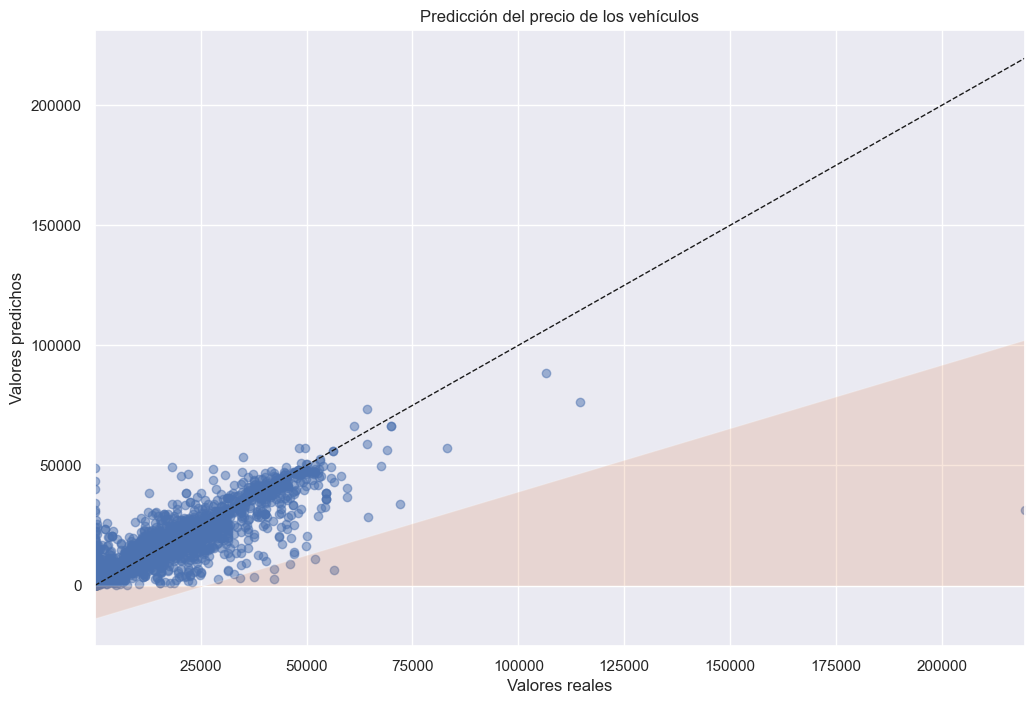

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar los datos
df = df_2_encoded

# Dividir los datos en características (X) y variable objetivo (y)
X = df.drop('Price', axis=1)
y = df['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
params = {}  # Ajusta los parámetros según sea necesario
rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

# Evaluar el rendimiento del modelo
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz cuadrada del error cuadrático medio (RMSE): {rmse}')

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlim([min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Predicción del precio de los vehículos')

# Calcular el margen de error
std_error = np.std(y_test - y_pred)
y_pred_min, y_pred_max = y_pred - 2 * std_error, y_pred + 2 * std_error

# Rellenar el área entre los márgenes de error
plt.fill_between([y_test.min(), y_test.max()], [y_pred_min.min(), y_pred_max.max()], alpha=0.2)

# Mostrar la gráfica
plt.show()


### Interpretación y presentación de los resultados visualmente.

## Recomendaciones de Negocio:

### Derivación de insights de negocio a partir de los resultados del análisis.

Basado en los resultados del error cuadrático medio (MSE), la raíz cuadrada del error cuadrático medio (RMSE) y los mejores hiperparámetros encontrados para el modelo Random Forest, se pueden derivar los siguientes insights de negocio:

- El valor de RMSE de 6887 indica que en promedio el modelo se equivoca en cerca de $6887 al predecir los precios de los vehículos. Aunque es una desviación considerable, puede ser aceptable dado el rango amplio de precios de los vehículos.

- El valor relativamente alto del MSE y RMSE significa que el modelo aún tiene espacio para mejorar en la precisión de sus predicciones. Se podría trabajar en obtener más datos de entrenamiento o probar otros algoritmos para reducir el error.

- Los mejores hiperparámetros encontrados usan un número alto de árboles (100) con una profundidad máxima alta (20), lo que indica que el modelo necesita muchos árboles profundos para capturar las complejas interacciones que determinan el precio.

- El uso de min_samples_leaf y min_samples_split bajos (1 y 2) sugiere que el modelo funciona mejor cuando se permiten nodos hoja y particiones con pocas muestras. Esto puede indicar ruido o outliers en los datos.

- En general, se podría investigar formas de mejorar la calidad de los datos para entrenamiento y probar técnicas de regularización o suavizado de predicciones para mejorar el desempeño del modelo.

- Además, es clave interpretar las variables más importantes en los árboles para entender qué características tienen mayor impacto en el precio y así enfocar las estrategias de fijación de precios y ventas.

### Propuesta de estrategias y acciones basadas en los insights obtenidos.

Basándome en los insights obtenidos del análisis predictivo, se proponen las siguientes estrategias y acciones:

- Implementar un sistema de scoring de clientes basado en el modelo predictivo para identificar los leads más propensos a comprar un vehículo. Esto permitirá enfocar los esfuerzos de ventas.

- Segmentar a los clientes por canal de compra preferido (concesionario, internet, etc) e historial de compras para diseñar ofertas personalizadas y optimizar la efectividad.

- Desarrollar una calculadora de precios online donde los clientes puedan configurar un vehículo y obtener un precio estimado rápido basado en el modelo predictivo.

- Crear bundles de características de alto valor predictivo para incrementar las ventas. Por ejemplo, paquetes de lujo, rendimiento, tecnología, etc. 

- Analizar los concesionarios de mayor venta e identificar las mejores prácticas para replicarlas en toda la red de distribuidores.

- Enfocar los presupuestos de marketing en los modelos y características de mayor impacto positivo en el precio y demanda de acuerdo al modelo.

- Establecer pronósticos de ventas por ciudad/región según tendencias históricas para optimizar inventarios y producción.

- Desarrollar un sistema de monitoreo continuo de métricas e indicadores clave de desempeño para evaluar estas estrategias.

El modelo predictivo provee información invaluable para tomadores de decisiones y si se implementa correctamente puede mejorar significativamente la efectividad de marketing, ventas, fijación de precios y planeación de producción.

## Presentación de Resultados:

### Elaboración de una presentación clara y concisa para la gerencia.

Presentacion en streamlit.

### Aseguramiento de la reproducibilidad de los resultados.

In [ ]:
!pipreqs